In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.ndimage import convolve

In [8]:
# **Explication :**
# Objectif : Implémenter  les opérateurs Roberts, Prewitt et Sobel en créant les masques et en effectuant la convolution.

# Charger l'image en niveaux de gris
image = cv2.imread('/content/camman.tif', 0)

#I. Détection des contours avec des masques classiques

In [9]:
# Ajouter du bruit "sel et poivre"
def add_salt_pepper_noise(img, prob):
    noisy_img = np.copy(img)
    num_salt = int(prob * img.size * 0.5)
    num_pepper = int(prob * img.size * 0.5)

    # Ajouter sel
    coords_salt = [np.random.randint(0, i - 1, num_salt) for i in img.shape]
    noisy_img[coords_salt[0], coords_salt[1]] = 255

    # Ajouter poivre
    coords_pepper = [np.random.randint(0, i - 1, num_pepper) for i in img.shape]
    noisy_img[coords_pepper[0], coords_pepper[1]] = 0

    return noisy_img


In [10]:
# Fonction pour appliquer un masque
def apply_mask(image, kernel):
    img_h, img_w = image.shape
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2

    # Ajouter un padding à l'image
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    output = np.zeros_like(image)

    # Convolution
    for i in range(img_h):
        for j in range(img_w):
            region = padded_image[i:i + k_h, j:j + k_w]
            output[i, j] = abs(np.sum(region * kernel))

    return output

In [11]:
# Définir les masques de Roberts, Prewitt et Sobel
roberts_x = np.array([[1, 0], [0, -1]])
roberts_y = np.array([[0, 1], [-1, 0]])

prewitt_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
prewitt_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])


In [12]:
# Ajouter du bruit à l'image
noisy_image = add_salt_pepper_noise(image, 0.05)

# Appliquer les masques
roberts_result_x = apply_mask(noisy_image, roberts_x)
roberts_result_y = apply_mask(noisy_image, roberts_y)
roberts_result = np.sqrt(roberts_result_x**2 + roberts_result_y**2)

prewitt_result_x = apply_mask(noisy_image, prewitt_x)
prewitt_result_y = apply_mask(noisy_image, prewitt_y)
prewitt_result = np.sqrt(prewitt_result_x**2 + prewitt_result_y**2)

sobel_result_x = apply_mask(noisy_image, sobel_x)
sobel_result_y = apply_mask(noisy_image, sobel_y)
sobel_result = np.sqrt(sobel_result_x**2 + sobel_result_y**2)


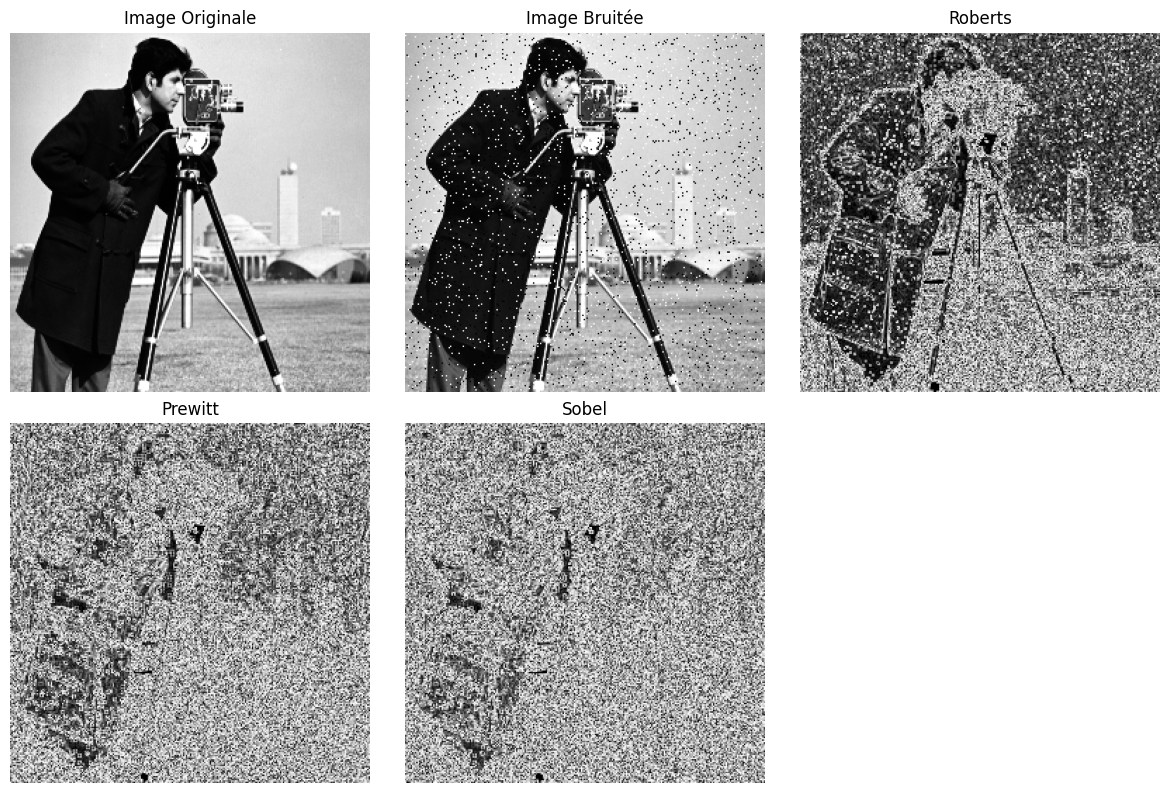

In [13]:
# Afficher les résultats
titles = ['Image Originale', 'Image Bruitée', 'Roberts', 'Prewitt', 'Sobel']
images = [image, noisy_image, roberts_result, prewitt_result, sobel_result]

plt.figure(figsize=(12, 8))
for i in range(len(images)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

**Explication :**

Dans cette partie, nous avons implémenté et appliqué manuellement les opérateurs de détection de contours Roberts, Prewitt et Sobel. Ces méthodes ont été testées sur une image originale ainsi qu'une image bruitée (avec du bruit sel et poivre). Voici une analyse des forces et faiblesses de chaque méthode :

- **Méthode de Roberts :**

  - **Forces :**
   - Très simple et rapide à calculer grâce à ses petits masques 2×2.

   - Bien adaptée pour détecter les contours fins dans des images simples.

 - **Faiblesses :**

   - Très sensible au bruit, car les petits masques ne permettent pas de prendre en compte suffisamment de pixels environnants.

   - Moins précise pour les contours plus complexes ou lorsque l'image contient beaucoup de détails.

- **Méthode de Prewitt :**

  - **Forces :**

    - Masques 3×3 qui offrent une meilleure stabilité par rapport au bruit que Roberts.

    - Capable de détecter les contours horizontaux et verticaux avec une bonne précision.

 - **Faiblesses :**

   - Moins robuste face à un bruit intense (comme du bruit gaussien), car les coefficients des masques sont uniformes.

   - La qualité des contours détectés peut être inférieure à celle de Sobel dans des cas complexes.

- **Méthode de Sobel :**

  - **Forces :**

   - Les masques 3×3 avec des coefficients pondérés au centre permettent une meilleure détection des contours même en présence de bruit modéré.

   - Produit des contours plus lisses et plus précis, surtout dans des images contenant des gradients forts.

  - **Faiblesses :**

   - Plus lent à calculer que Roberts en raison des coefficients plus complexes.

   - Bien qu'il soit plus robuste que Prewitt, il reste sensible au bruit très intense (exemple : sel et poivre avec une probabilité élevée).

**Synthèse comparative :**

- **Robustesse au bruit : Sobel > Prewitt > Roberts.**

- **Qualité des contours : Sobel > Prewitt > Roberts.**

- **Complexité de calcul : Roberts < Prewitt < Sobel.**


**En conclusion,** la méthode de Sobel offre le meilleur compromis entre robustesse au bruit et qualité des contours, bien qu'elle soit légèrement plus complexe à implémenter et calculer. Roberts, en revanche, est adapté pour des applications simples où la vitesse est prioritaire, tandis que Prewitt offre une solution intermédiaire.

# II. Détection des contours avec le Laplacien de la gaussienne

## 1) Fonction pour retourner la valeur de LG(i,j,σ)

In [14]:
def LG_value(i, j, sigma):
    """
    Calcule la valeur du Laplacien de la gaussienne (LG) en un point (i, j) pour une valeur de sigma donnée.
    """
    r_squared = i ** 2 + j ** 2
    return (1 / (math.pi * sigma ** 4)) * (1 - (r_squared / (2 * sigma ** 2))) * math.exp(-r_squared / (2 * sigma ** 2))


## 2) Fonction pour calculer le masque de taille 5×5

In [15]:
def gaussian_laplacian(sigma):
    """
    Génère un masque de Laplacien de la gaussienne (taille 5x5) pour une valeur de sigma donnée.
    """
    size = 5  # Taille fixe du noyau
    kernel = np.zeros((size, size))  # Initialiser un noyau vide
    offset = size // 2  # Décalage pour centrer le noyau
    for i in range(-offset, offset + 1):
        for j in range(-offset, offset + 1):
            kernel[i + offset, j + offset] = LG_value(i, j, sigma)
    return kernel


## 3) Fonction pour calculer la convolution f∗g′′

In [16]:
def convolve_image(image, kernel):
    """
    Applique la convolution manuelle entre une image et un noyau (kernel).
    """
    img_h, img_w = image.shape
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2

    # Ajouter un padding à l'image
    padded_image = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant', constant_values=0)
    output = np.zeros_like(image)

    # Convolution manuelle
    for i in range(img_h):
        for j in range(img_w):
            region = padded_image[i:i + k_h, j:j + k_w]
            output[i, j] = np.sum(region * kernel)

    return output


## 4) Fonction pour détecter les passages par zéro

In [17]:
def detect_zero_crossings(convolved_image):
    """
    Localise les passages par zéro en détectant les changements de signe dans l'image convoluée.
    """
    output = np.zeros_like(convolved_image, dtype=np.uint8)
    rows, cols = convolved_image.shape

    # Parcourir chaque pixel
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            # Vérifier les passages par zéro verticalement
            if convolved_image[i, j] * convolved_image[i, j + 1] < 0:
                output[i, j] = 255  # Passage par zéro vertical
            # Vérifier les passages par zéro horizontalement
            if convolved_image[i, j] * convolved_image[i + 1, j] < 0:
                output[i, j] = 255  # Passage par zéro horizontal

    return output


In [18]:
# Définir la valeur de sigma pour le Laplacien de la gaussienne
sigma = 0.625

# Calculer le masque du Laplacien de la gaussienne
laplacian_mask = gaussian_laplacian(sigma)
print("Masque du Laplacien de la Gaussienne :\n", laplacian_mask)

# Appliquer la convolution de l'image avec le masque du Laplacien de la gaussienne
convolved_image = convolve_image(image, laplacian_mask)

# Détecter les passages par zéro
zero_crossings = detect_zero_crossings(convolved_image)

Masque du Laplacien de la Gaussienne :
 [[-6.88377290e-04 -1.87171247e-02 -5.13617162e-02 -1.87171247e-02
  -6.88377290e-04]
 [-1.87171247e-02 -2.51571120e-01 -1.62401917e-01 -2.51571120e-01
  -1.87171247e-02]
 [-5.13617162e-02 -1.62401917e-01  2.08607567e+00 -1.62401917e-01
  -5.13617162e-02]
 [-1.87171247e-02 -2.51571120e-01 -1.62401917e-01 -2.51571120e-01
  -1.87171247e-02]
 [-6.88377290e-04 -1.87171247e-02 -5.13617162e-02 -1.87171247e-02
  -6.88377290e-04]]


<ipython-input-17-35149312717e>:12: RuntimeWarning: overflow encountered in scalar multiply
  if convolved_image[i, j] * convolved_image[i, j + 1] < 0:
<ipython-input-17-35149312717e>:15: RuntimeWarning: overflow encountered in scalar multiply
  if convolved_image[i, j] * convolved_image[i + 1, j] < 0:


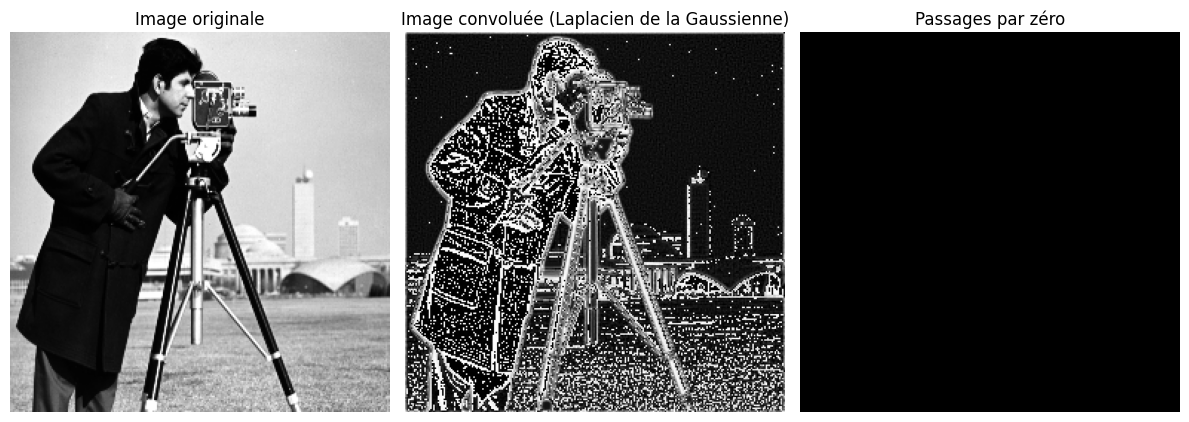

In [19]:
# 5) Affichage des résultats
plt.figure(figsize=(12, 8))

# Image originale
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Image originale")
plt.axis('off')

# Image convoluée
plt.subplot(1, 3, 2)
plt.imshow(convolved_image, cmap='gray')
plt.title("Image convoluée (Laplacien de la Gaussienne)")
plt.axis('off')

# Passages par zéro
plt.subplot(1, 3, 3)
plt.imshow(zero_crossings, cmap='gray')
plt.title("Passages par zéro")
plt.axis('off')

plt.tight_layout()
plt.show()

#III. Détection des contours par le filtre de Canny

##  Fonction pour retourner la valeur de h(i,j,σ)

In [20]:
def gaussian_kernel(sigma):
    # Calculer un noyau gaussien de taille 5x5 pour simplifier
    kernel_size = 5
    kernel = np.zeros((kernel_size, kernel_size))
    center = kernel_size // 2

    for i in range(kernel_size):
        for j in range(kernel_size):
            x = i - center
            y = j - center
            kernel[i, j] = (1 / (2 * np.pi * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))

    return kernel

## Calculer le masque de taille 5×5 représentant le noyau gaussien

In [21]:
def apply_gaussian_filter(image, sigma):
    kernel = gaussian_kernel(sigma)
    return convolution(image, kernel)


## Fonction de produit de convolution f∗h

In [31]:
def convolution(image, kernel):
    """
    Effectue une convolution entre l'image et le noyau (kernel).
    Args:
    - image: L'image d'entrée (matrice 2D).
    - kernel: Le noyau à appliquer (matrice 2D).

    Returns:
    - result: Le résultat de la convolution (matrice 2D).
    """
    # Récupérer les dimensions de l'image et du noyau
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    # Calculer les bords de l'image (pour éviter les dépassements)
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2

    # Ajouter des zéros autour de l'image pour la gestion des bords
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)

    # Créer une matrice vide pour stocker le résultat
    result = np.zeros_like(image)

    # Appliquer la convolution
    for i in range(image_height):
        for j in range(image_width):
            # Extraire la région de l'image correspondant à la taille du noyau
            region = padded_image[i:i+kernel_height, j:j+kernel_width]

            # Effectuer la multiplication élément par élément et sommer
            result[i, j] = np.sum(region * kernel)

    return result


## Calcul des dérivées horizontale et verticale

In [22]:
def sobel_derivatives(image):
    # Filtres de Sobel pour dérivées horizontale et verticale
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    grad_x = convolution(image, sobel_x)
    grad_y = convolution(image, sobel_y)

    return grad_x, grad_y


## Calcul de l’amplitude du gradient et l’orientation

In [23]:
def gradient_magnitude_and_orientation(grad_x, grad_y):
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    orientation = np.arctan2(grad_y, grad_x)

    return magnitude, orientation


## Élimination des pixels non-maximaux (Amincissement)

In [24]:
def non_maximum_suppression(magnitude, orientation):
    # Créer une copie de la magnitude pour y apporter des modifications
    suppressed = np.copy(magnitude)

    # Convertir les orientations en angles
    angle = orientation * 180 / np.pi
    angle = np.where(angle < 0, angle + 180, angle)

    for i in range(1, magnitude.shape[0] - 1):
        for j in range(1, magnitude.shape[1] - 1):
            # Angles pour la direction du gradient
            angle_val = angle[i, j]

            if (0 <= angle_val < 22.5) or (157.5 <= angle_val <= 180):
                neighbor1, neighbor2 = magnitude[i, j-1], magnitude[i, j+1]
            elif (22.5 <= angle_val < 67.5):
                neighbor1, neighbor2 = magnitude[i-1, j+1], magnitude[i+1, j-1]
            elif (67.5 <= angle_val < 112.5):
                neighbor1, neighbor2 = magnitude[i-1, j], magnitude[i+1, j]
            else:
                neighbor1, neighbor2 = magnitude[i-1, j-1], magnitude[i+1, j+1]

            # Comparaison avec les voisins
            if magnitude[i, j] < neighbor1 or magnitude[i, j] < neighbor2:
                suppressed[i, j] = 0

    return suppressed


## Seuillage par hystérésis

In [25]:
def hysteresis_thresholding(image, low_threshold, high_threshold):
    result = np.zeros_like(image)

    strong_edge = np.where(image >= high_threshold)
    weak_edge = np.where((image >= low_threshold) & (image < high_threshold))

    result[strong_edge] = 1  # Marquer les bords forts
    result[weak_edge] = 0.5  # Marquer les bords faibles

    return result


## Convolution

In [28]:
def convolution(image, kernel):
    return convolve(image, kernel)


In [29]:
def canny_edge_detection(image, sigma, low_threshold, high_threshold):
    # Étape 1: Lissage gaussien
    blurred_image = apply_gaussian_filter(image, sigma)

    # Étape 2: Calcul des dérivées horizontale et verticale
    grad_x, grad_y = sobel_derivatives(blurred_image)

    # Étape 3: Calcul de l'amplitude du gradient et de l'orientation
    magnitude, orientation = gradient_magnitude_and_orientation(grad_x, grad_y)

    # Étape 4: Éliminer les pixels non-maximaux
    thin_edges = non_maximum_suppression(magnitude, orientation)

    # Étape 5: Seuillage par hystérésis
    edges = hysteresis_thresholding(thin_edges, low_threshold, high_threshold)

    return edges


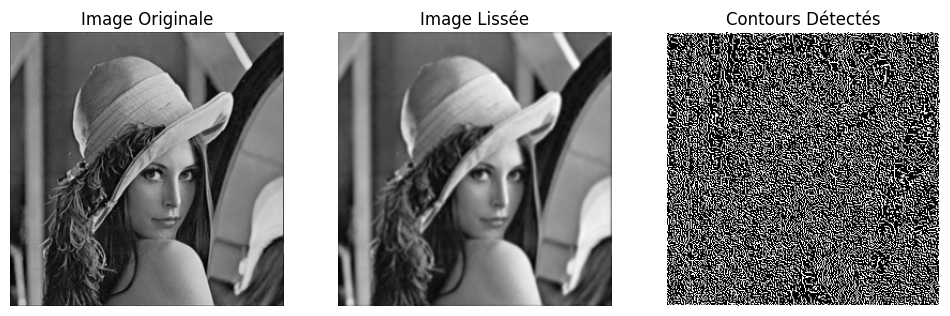

In [33]:
from scipy.ndimage import convolve

# Étape 1: Lire l'image en niveau de gris
image = cv2.imread("/content/lena.tif", cv2.IMREAD_GRAYSCALE)

# Fonction pour calculer le noyau gaussien
def gaussian_kernel(sigma):
    kernel_size = 5
    kernel = np.zeros((kernel_size, kernel_size))
    center = kernel_size // 2

    for i in range(kernel_size):
        for j in range(kernel_size):
            x = i - center
            y = j - center
            kernel[i, j] = (1 / (2 * np.pi * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))

    return kernel

# Fonction de convolution
def convolve_image(image, kernel):
    return convolve(image, kernel)

# Fonction pour calculer les dérivées horizontales
def calculate_derivative_x(image):
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    return convolve_image(image, sobel_x)

# Fonction pour calculer les dérivées verticales
def calculate_derivative_y(image):
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    return convolve_image(image, sobel_y)

# Fonction pour calculer l'amplitude du gradient
def gradient_magnitude(derivative_x, derivative_y):
    return np.sqrt(derivative_x**2 + derivative_y**2)

# Fonction pour calculer l'orientation du gradient
def gradient_orientation(derivative_x, derivative_y):
    return np.arctan2(derivative_y, derivative_x)

# Fonction d'élimination des pixels non-maximaux (amincissement)
def non_max_suppression(magnitude, orientation):
    suppressed = np.copy(magnitude)
    angle = orientation * 180 / np.pi
    angle = np.where(angle < 0, angle + 180, angle)

    for i in range(1, magnitude.shape[0] - 1):
        for j in range(1, magnitude.shape[1] - 1):
            angle_val = angle[i, j]

            if (0 <= angle_val < 22.5) or (157.5 <= angle_val <= 180):
                neighbor1, neighbor2 = magnitude[i, j-1], magnitude[i, j+1]
            elif (22.5 <= angle_val < 67.5):
                neighbor1, neighbor2 = magnitude[i-1, j+1], magnitude[i+1, j-1]
            elif (67.5 <= angle_val < 112.5):
                neighbor1, neighbor2 = magnitude[i-1, j], magnitude[i+1, j]
            else:
                neighbor1, neighbor2 = magnitude[i-1, j-1], magnitude[i+1, j+1]

            if magnitude[i, j] < neighbor1 or magnitude[i, j] < neighbor2:
                suppressed[i, j] = 0

    return suppressed

# Fonction de seuillage par hystérésis
def hysteresis_thresholding(suppressed, low_threshold, high_threshold):
    strong_edges = suppressed > high_threshold
    weak_edges = (suppressed >= low_threshold) & (suppressed <= high_threshold)

    return strong_edges, weak_edges

# Paramètres pour la détection de Canny
sigma = 1
low_threshold = 0.05
high_threshold = 0.15

# Étape 2: Lissage gaussien
kernel = gaussian_kernel(sigma)
smoothed_image = convolve_image(image, kernel)

# Étape 3: Calcul des dérivées horizontales et verticales
derivative_x = calculate_derivative_x(smoothed_image)
derivative_y = calculate_derivative_y(smoothed_image)

# Étape 4: Calcul de l'amplitude du gradient et de l'orientation
magnitude = gradient_magnitude(derivative_x, derivative_y)
orientation = gradient_orientation(derivative_x, derivative_y)

# Étape 5: Élimination des pixels non-maximaux
suppressed = non_max_suppression(magnitude, orientation)

# Étape 6: Seuillage par hystérésis
strong_edges, weak_edges = hysteresis_thresholding(suppressed, low_threshold, high_threshold)

# Affichage des résultats côte à côte

plt.figure(figsize=(12, 4))

# Afficher l'image originale
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Image Originale")
plt.axis('off')  # Désactiver les axes

# Afficher l'image lissée
plt.subplot(1, 3, 2)
plt.imshow(smoothed_image, cmap='gray')
plt.title("Image Lissée")
plt.axis('off')  # Désactiver les axes

# Afficher les contours détectés
plt.subplot(1, 3, 3)
plt.imshow(strong_edges + weak_edges, cmap='gray')
plt.title("Contours Détectés")
plt.axis('off')  # Désactiver les axes

plt.show()


# IV. Détection de lignes et de coins

## Transformée de Hough pour la détection de lignes

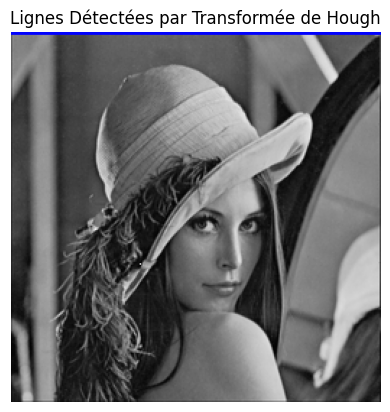

In [39]:
import cv2


# Lire l'image en niveaux de gris
image = cv2.imread("/content/lena.tif", cv2.IMREAD_GRAYSCALE)

# Appliquer le détecteur de bords de Canny
edges = cv2.Canny(image, 50, 150)

# Appliquer la transformée de Hough pour la détection de lignes
lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)

# Afficher l'image originale avec les lignes détectées
image_lines = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

if lines is not None:
    for line in lines:
        rho, theta = line[0]
        x1 = int(rho * np.cos(theta) + 1000 * (-np.sin(theta)))
        y1 = int(rho * np.sin(theta) + 1000 * (np.cos(theta)))
        x2 = int(rho * np.cos(theta) - 1000 * (-np.sin(theta)))
        y2 = int(rho * np.sin(theta) - 1000 * (np.cos(theta)))
        cv2.line(image_lines, (x1, y1), (x2, y2), (0, 0, 255), 2)

# Affichage des résultats
plt.imshow(image_lines)
plt.title("Lignes Détectées par Transformée de Hough")
plt.axis('off')
plt.show()


## Détecteur de Harris pour la détection de coins

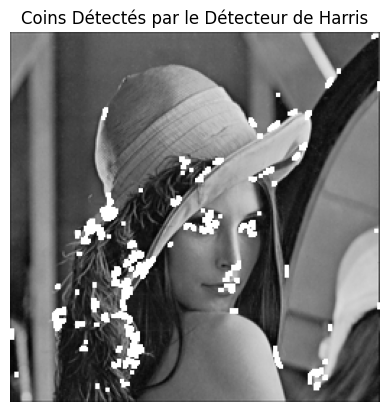

In [40]:
# Lire l'image en niveaux de gris
image = cv2.imread("/content/lena.tif", cv2.IMREAD_GRAYSCALE)

# Appliquer un flou gaussien pour réduire le bruit
image_blurred = cv2.GaussianBlur(image, (5, 5), 0)

# Appliquer le détecteur de Harris
dst = cv2.cornerHarris(image_blurred, 2, 3, 0.04)

# Seuil pour marquer les coins
dst = cv2.dilate(dst, None)  # Dilater pour mieux voir les coins
image_harris = np.copy(image)

# Appliquer un seuil pour détecter les coins
image_harris[dst > 0.01 * dst.max()] = 255

# Affichage des résultats
plt.imshow(image_harris, cmap='gray')
plt.title("Coins Détectés par le Détecteur de Harris")
plt.axis('off')
plt.show()
